# Problem statement

The idea is to forecast the mean of Invasive ventilators available in the US for the upcoming 3 months based on the historical data we're having and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [5]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format

In [6]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [7]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs.csv')


# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2020-01-03       0.0000        0.0000        0.0000   
1   2       Abruzzo  2020-01-04       0.0000        0.0000        0.0000   
2   3       Abruzzo  2020-01-05       0.0000        0.0000        0.0000   
3   4       Abruzzo  2020-01-06       0.0000        0.0000        0.0000   
4   5       Abruzzo  2020-01-07       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  newICU_upper  \
0       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
1       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
2       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
3       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
4       0.0000        0.0000        0.0000       0.0000  ...        0.0000   

   totdea_mean  totdea_lower  totdea_upper  bedover_mean  bedover_lower  \

# Data pre-processing

* We're grouping by date and applying sum because we have data on states and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all those rows which have zeroes in mean, lower bound and upper bound columns

In [8]:
data = data[['date', 'InvVen_mean',  'InvVen_lower',  'InvVen_upper']] .groupby(['date']).sum().reset_index()
data = data[(data['InvVen_mean']!=0) & (data['InvVen_lower']!=0) & (data['InvVen_upper']!=0)]

In [9]:
# Fetching only columns of interest
InvVenData = data[['date', 'InvVen_mean']]
InvVenData.head()

,date,InvVen_mean
47,2020-02-19,14.0000
48,2020-02-20,20.0000
49,2020-02-21,30.0000
50,2020-02-22,44.8616
51,2020-02-23,59.6926


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [10]:
InvVenData['date'] = pd.to_datetime(InvVenData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final invasive ventilators value corresponding to each date.

### Grouping the column by date

In [11]:
InvVenData = InvVenData.groupby(['date']).sum().reset_index()
InvVenData.iloc[50:100]

,date,InvVen_mean
50,2020-04-09,68105.5997
51,2020-04-10,69163.3055
52,2020-04-11,69666.1344
53,2020-04-12,70152.3573
54,2020-04-13,71302.2334
55,2020-04-14,72196.8523
56,2020-04-15,69541.9313
57,2020-04-16,67684.8152
58,2020-04-17,66060.6549
59,2020-04-18,63972.7197


In [12]:
#setting index to date
InvVenData = InvVenData.set_index('date')
InvVenData.index

DatetimeIndex(['2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28',
               ...
               '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02',
               '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08'],
              dtype='datetime64[ns]', name='date', length=141, freq=None)

In [13]:
# Keeping historical data till 25th April 2020
InvVenData = InvVenData[InvVenData.index <= '2020-04-25']
InvVenData.columns = ['value']
InvVenData.tail()

,value
date,
2020-04-21,58881.8253
2020-04-22,55737.7532
2020-04-23,52713.5734
2020-04-24,49541.6853
2020-04-25,46038.8484


### Missing value analysis

We'll check if there's any missing value present in our data by applying isnull function on the dataset.

In [14]:
InvVenData.isnull().any()

value    False
dtype: bool

Since, we get False as the result, we can say that there're no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

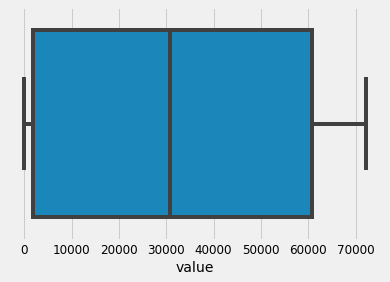

In [15]:
import seaborn as sns
sns.boxplot(x=InvVenData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [16]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(InvVenData))
print(z)

[[1.15562923]
 [1.15541465]
 [1.15505701]
 [1.1545255 ]
 [1.15399509]
 [1.15328382]
 [1.15286536]
 [1.15145316]
 [1.14937112]
 [1.14720561]
 [1.14382303]
 [1.13946196]
 [1.13724241]
 [1.12754848]
 [1.12053607]
 [1.10799062]
 [1.09454819]
 [1.07934628]
 [1.05846631]
 [1.04920073]
 [1.01523392]
 [0.9822151 ]
 [0.95436997]
 [0.91176472]
 [0.86567168]
 [0.79336641]
 [0.7222842 ]
 [0.65451687]
 [0.5740568 ]
 [0.472479  ]
 [0.37184177]
 [0.28582847]
 [0.17327981]
 [0.05271718]
 [0.04674922]
 [0.14162189]
 [0.28002477]
 [0.41490943]
 [0.52790322]
 [0.64186304]
 [0.76069306]
 [0.82844243]
 [0.86041868]
 [0.97581595]
 [1.04814403]
 [1.11605383]
 [1.19583856]
 [1.29010804]
 [1.30518724]
 [1.24689325]
 [1.2795792 ]
 [1.31740669]
 [1.33538972]
 [1.35277885]
 [1.39390269]
 [1.42589759]
 [1.33094775]
 [1.26453039]
 [1.20644438]
 [1.13177207]
 [1.0796304 ]
 [0.99552412]
 [0.94970278]
 [0.83725909]
 [0.72910319]
 [0.6156647 ]
 [0.49039024]]


As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [17]:
# Converting allBedData into time-series
ts = InvVenData['value']
ts.head()

date
2020-02-19   14.0000
2020-02-20   20.0000
2020-02-21   30.0000
2020-02-22   44.8616
2020-02-23   59.6926
Name: value, dtype: float64

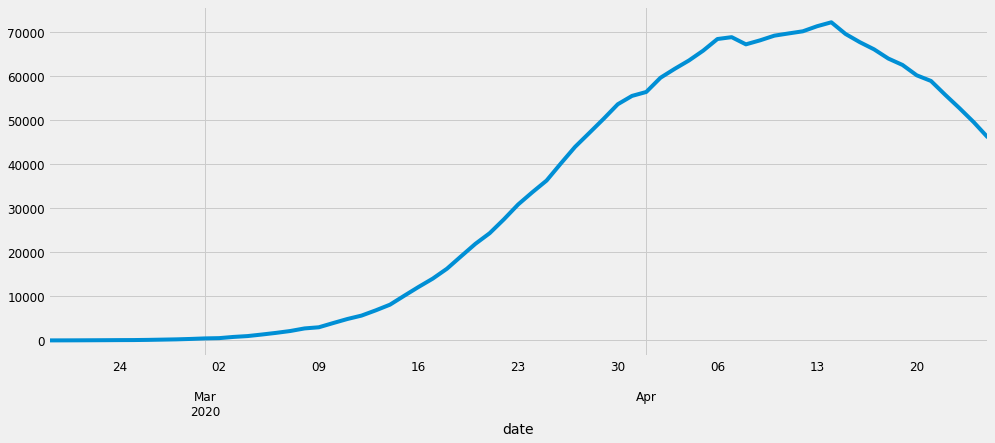

In [18]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increases till mid-April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

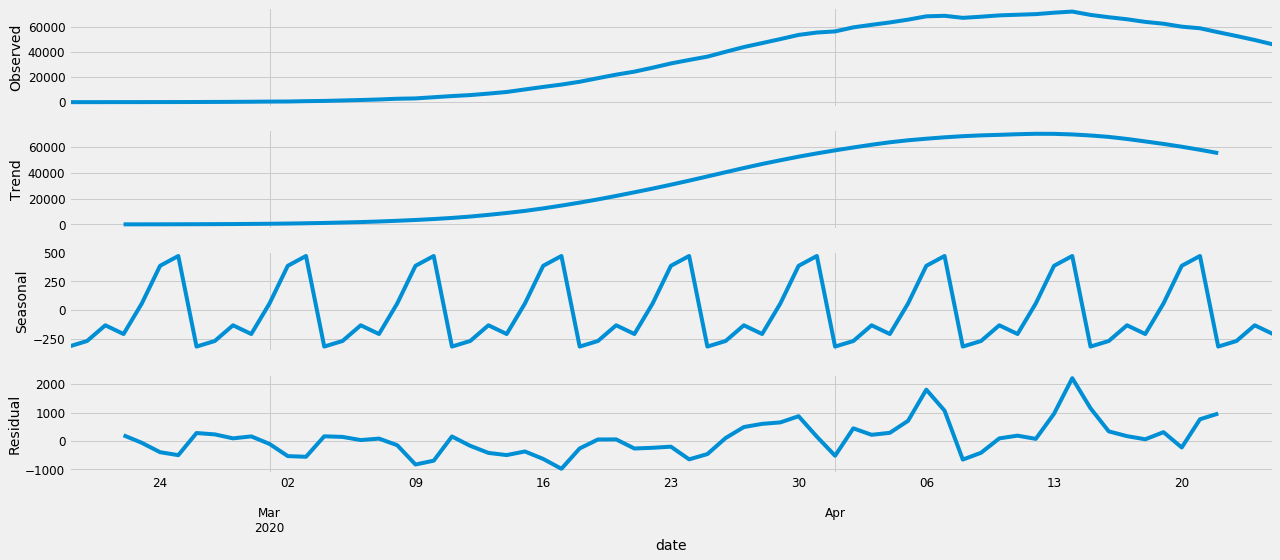

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking stationarity

 In a time series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

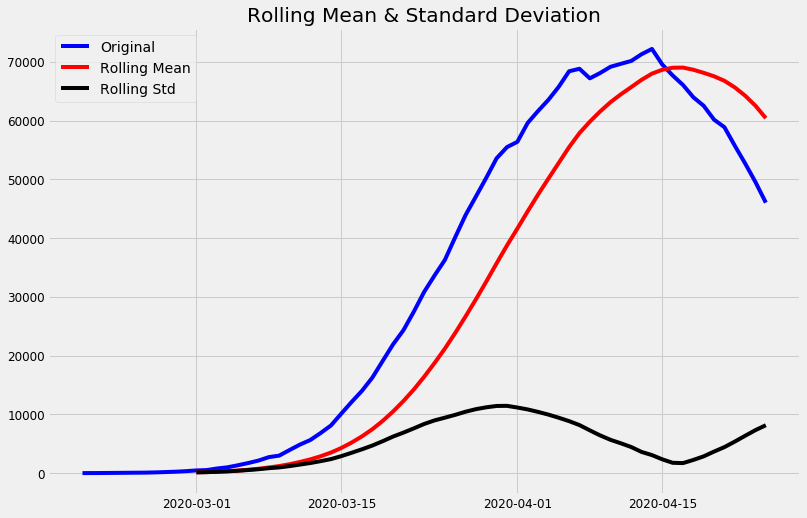

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.4063
p-value                        0.0000
#Lags Used                     7.0000
Number of Observations Used   59.0000
Critical Value (1%)           -3.5464
Critical Value (5%)           -2.9119
Critical Value (10%)          -2.5937
dtype: float64


In [21]:
test_stationarity(ts)

We can see that this time series is stationary with p value of 0.00.

# Plotting ACF and PACF 

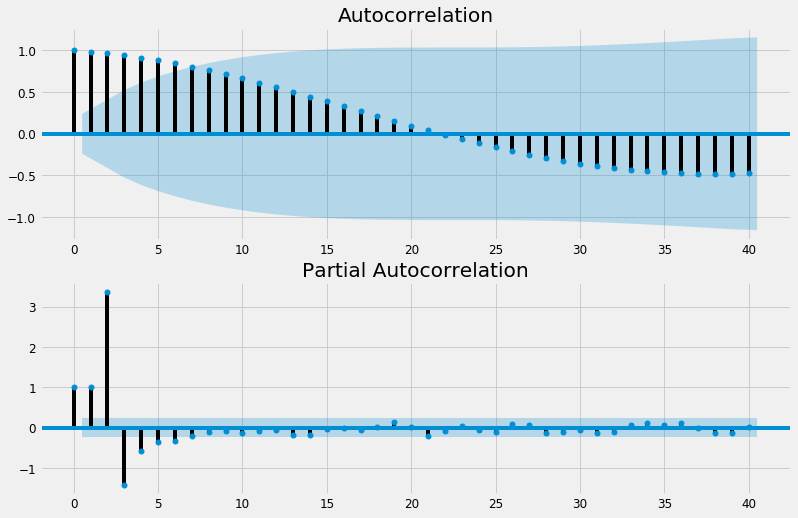

In [22]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 15 days, we're seeing some sine wave like pattern, let's consider SARIMA.

# Forecasting the time-series with ARIMA

### Understanding ARIMA

ARIMA, an acronym for Autoregressive Integrated Moving Average, is a combination of two terms - (i) AR (ii) MA
* AR corresponds to the difference value. This is today's value minus yesterday's value or value-on-value change.
* MA corresponds to moving average terms.

Besides this, we have seen that there's high amount of seasonality in the time-series. Therefore, we will be using Seasonal ARIMA or SARIMA in this case.

In [23]:
# Keeping the p, d and q to be bounded in [0,3)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


This step is parameter Selection for our SARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Parameters corresponding to lowest AIC are the ones that we'd choose.

In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1597.807043529907
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1300.7015481331948
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1230.8350265841111
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:921.6835077433286
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:963.7607608744901
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1143.5425654160622
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1250.3185212721514
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1165.1185445498738
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:977.2562351276557
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:920.7168205621875
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:716.2148155756897
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1163.0547018068607
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:946.7848630611248
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:936.7135444281543
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:674.9151924450852
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:674.5622142012907
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:383.10175391743167
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:379.0098543346734
ARI

ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:1039.3470460301037
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:881.1063102184154
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:836.7028879820421
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:699.5662623661742
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:652.815059890302
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:514.4292478833001
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:461.1951658076396
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:691.4853320316512
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:690.1793923240778
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:507.088481325366
ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:508.68093391153155
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:293.532238036281
ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:292.24161459496133
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1189.4299680132822
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:973.0775434777104
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:993.0924503119578
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:781.8752670834426
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:789.3521445970563
ARIMA(1, 

ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:501.29072971402974
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:481.0719503595421
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:675.8998929363129
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:674.5817395787303
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:491.79405521554037
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:493.0678916017911
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:277.18711144091014
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:279.181577960851
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:1013.0514633452336
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:831.3777556524278
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:848.754898861121
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:649.0740537617719
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:689.5311357176117
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:1336.1814810274927
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:862.3217029125124
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:833.3397756086744
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:681.7000463110419
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:650.8470148235549
ARIMA(1

ARIMA(2, 2, 0)x(2, 1, 1, 12)12 - AIC:475.06651310266943
ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:260.23034728658916
ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:261.9059140983627
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:1031.6538809087806
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:849.3124687733916
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:862.3474069778699
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:666.349461196382
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:701.2776302042437
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:1347.2130052853859
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:849.3105748861392
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:851.3080052344527
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:666.8155647651496
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:668.2471043348437
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:480.3670294088817
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:477.3909740420442
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:661.0562006731212
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:661.2343750876694
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:475.12030737898624
ARIMA(

We can see that (2, 2, 2)x(2, 2, 0, 12)12 - AIC: 254.46 corresponds to the lowest AIC value of 254.46.

# Fitting the SARIMA model

In [27]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   67
Model:             SARIMAX(2, 2, 2)x(2, 2, 0, 12)   Log Likelihood                -120.231
Date:                            Wed, 03 Jun 2020   AIC                            254.463
Time:                                    23:08:56   BIC                            259.419
Sample:                                02-19-2020   HQIC                           254.410
                                     - 04-25-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3129      0.190     -1.646      0.100      -0.685       0.060
ar.L2         -0.7938      0.184   

We can see that the model has the following features: 

* Skewness of 0.01 (<0.5)
* kurtosis of 1.93, close to 0
* Jarque-Bera statistic of 0.71 (close to zero) 
* All the above points mean that the model is close to normal distribution
* Also, AIC (254.46) is very low.

Thus, so far, we can see that statistics suggest we are having very good model.

# Running diagnosis

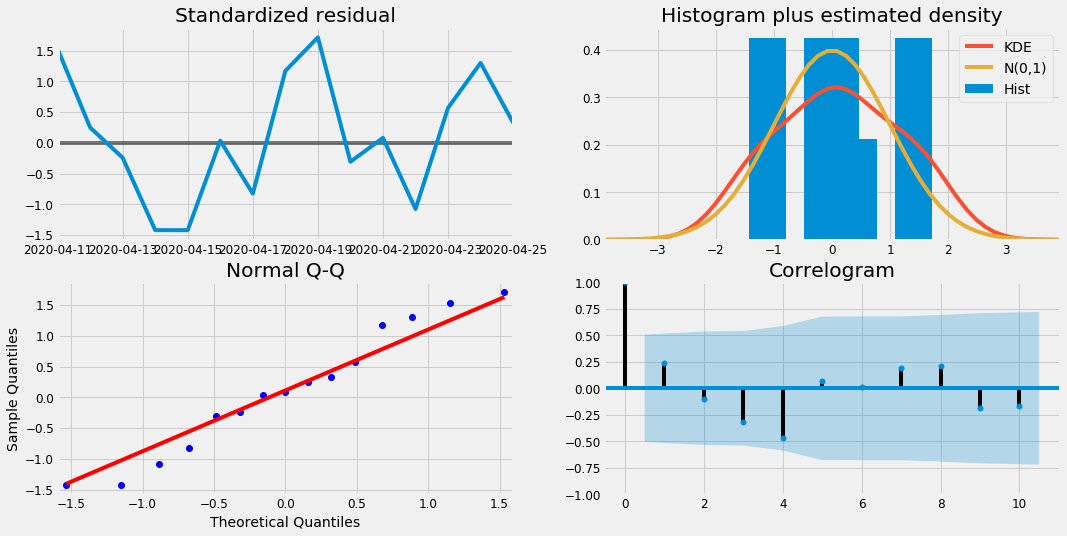

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The closer the sample quantiles are to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

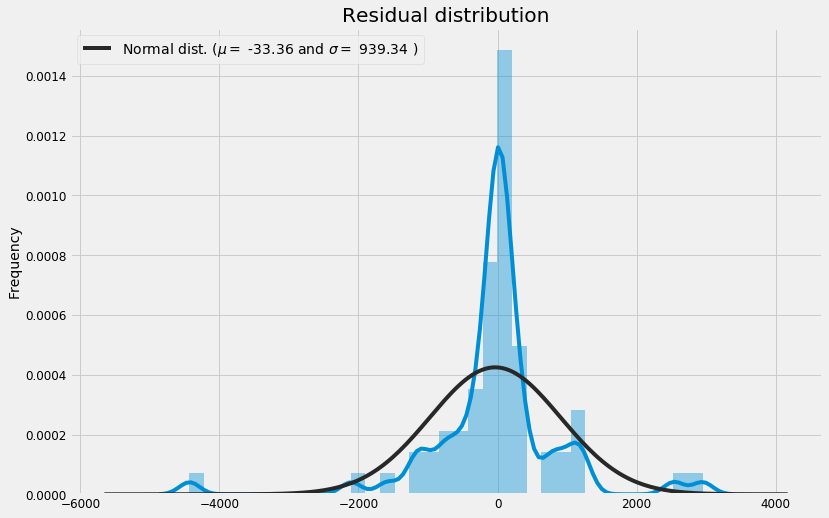

In [29]:
resid = results.resid

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high.

# Validating forecasts

Choosing March as a reference point to start validating the forecasts.

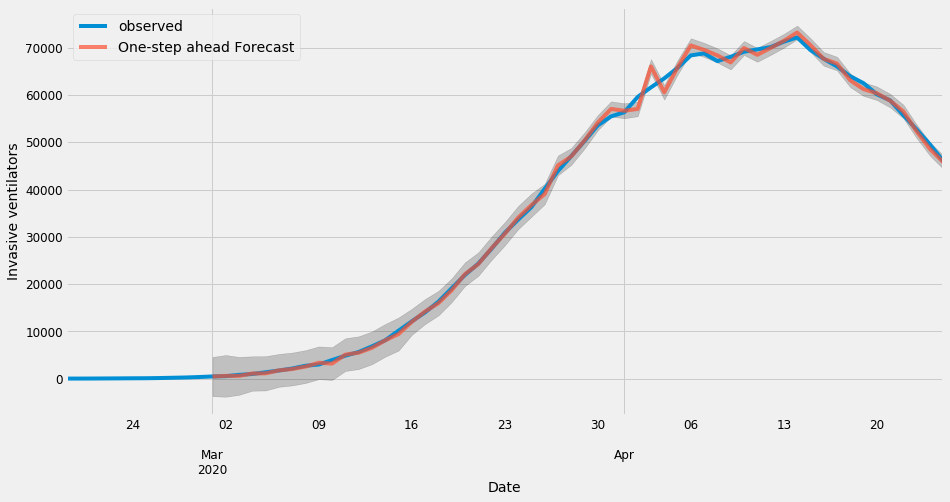

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive ventilators')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [31]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2020-04-01':]
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2056967.51


The MSE is very low.

In [32]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1434.21


In [33]:
ts.min()

14.0

In [34]:
ts.max()

72196.85226726312

This means that the value of RMSE is 1434.22. Also, the minimum and maximum values of time series is 14.0 and 72196.85226726312 respectively. Overall, this is a very good model so far.

# Visualizing forecasts

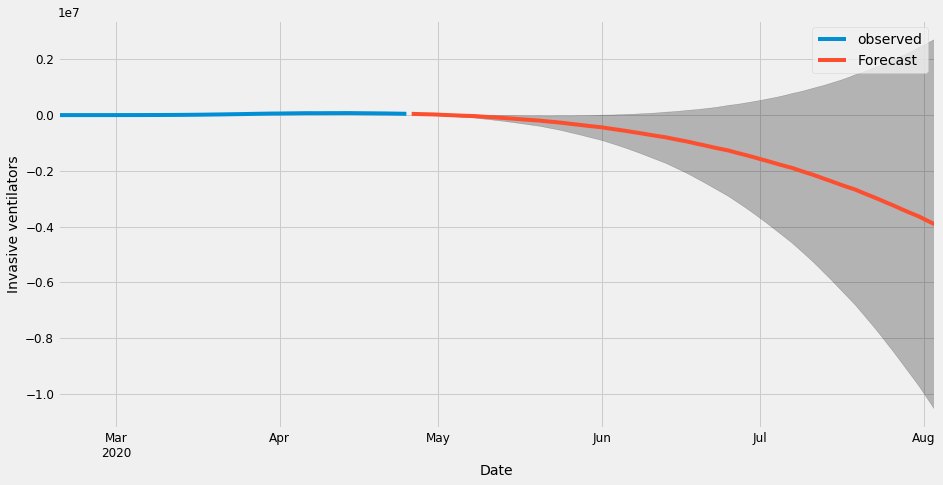

In [35]:
# Using the default confidence interval - 95%
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive ventilators')
plt.legend()
plt.show()

Thus, in the future, the number of invasive ventilators will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [36]:
# Setting all negative forecasted values to be 0
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean

2020-04-26   44816.9340
2020-04-27   38700.7987
2020-04-28   33335.2288
2020-04-29   28777.7476
2020-04-30   24096.8125
                ...    
2020-07-30       0.0000
2020-07-31       0.0000
2020-08-01       0.0000
2020-08-02       0.0000
2020-08-03       0.0000
Freq: D, Length: 100, dtype: float64

In [37]:
pred_ci['lower value'][pred_ci['lower value'] < 0] = 0
pred_ci['upper value'][pred_ci['upper value'] < 0] = 0
pred_ci

,lower value,upper value
2020-04-26,43394.4549,46239.4131
2020-04-27,34756.9566,42644.6409
2020-04-28,26259.7978,40410.6598
2020-04-29,18519.7421,39035.7532
2020-04-30,10298.0724,37895.5525
...,...,...
2020-07-30,0.0000,2346817.4375
2020-07-31,0.0000,2450788.1986
2020-08-01,0.0000,2540105.3497
2020-08-02,0.0000,2638045.3767


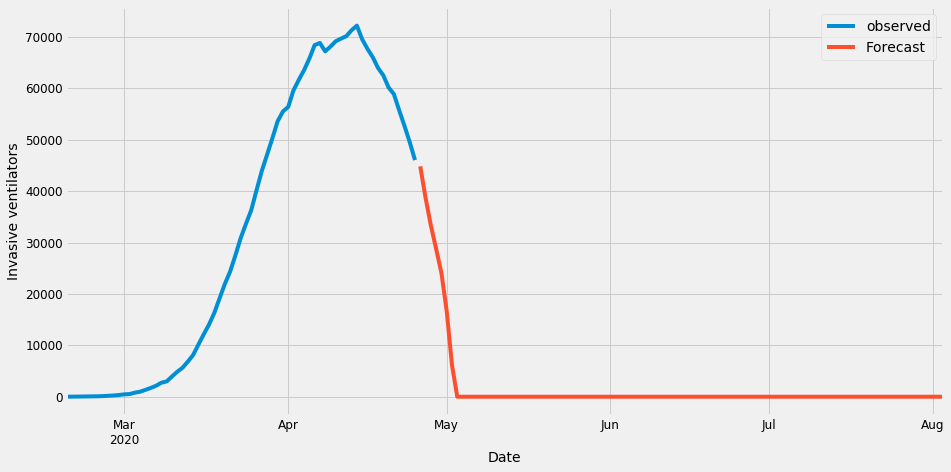

In [38]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Invasive ventilators')
plt.legend()
plt.show()

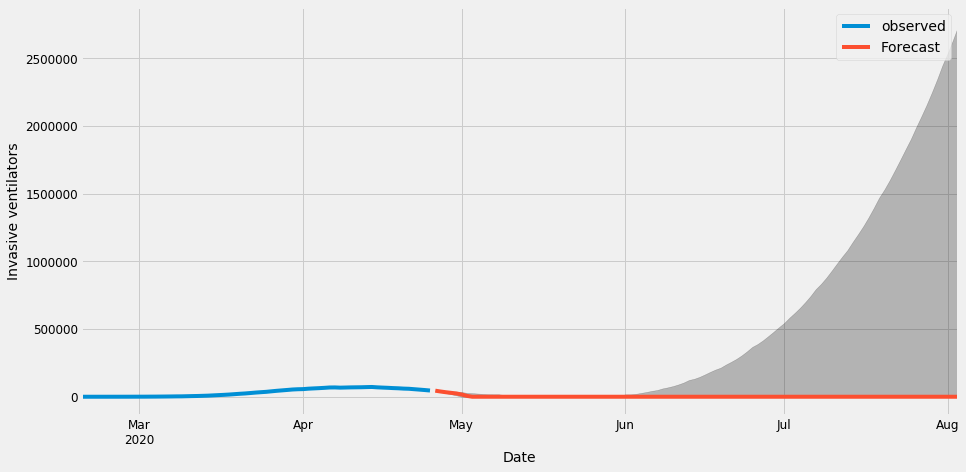

In [39]:
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive ventilators')
plt.legend()
plt.show()

In [40]:
# Predictions dataframe
InvVenPredictions = pd.DataFrame({'Predicted Mean Invasive ventilators':pred_uc.predicted_mean, 
                                   'Predicted lower value':pred_ci.iloc[:, 0], 
                                  'Predicted upper value': pred_ci.iloc[:, 1]})

In [41]:
InvVenPredictions.head(25)

,Predicted Mean Invasive ventilators,Predicted lower value,Predicted upper value
2020-04-26,44816.9340,43394.4549,46239.4131
2020-04-27,38700.7987,34756.9566,42644.6409
2020-04-28,33335.2288,26259.7978,40410.6598
2020-04-29,28777.7476,18519.7421,39035.7532
2020-04-30,24096.8125,10298.0724,37895.5525
2020-05-01,16676.9306,0.0000,34616.2280
2020-05-02,6193.0271,0.0000,28563.5917
2020-05-03,0.0000,0.0000,26726.8614
2020-05-04,0.0000,0.0000,23848.2718
2020-05-05,0.0000,0.0000,20824.7977
